# Shor's Algorithm Tutorial

*Author: Júlia Barberà Rodríguez*, 15th February of 2023

This notebook presents a code to find the factors of an integer $N$ using Shor's algorithm.

For computational reasons, it simulates the algorithm for $N = 91$.  

__Table of contents:__
1. [Period finding](#period-finding)

2. [Theoretical Background: Shor's algorithm](#Theoretical-Background-Shors-algorithm)
    1. [The Quantum Fourier transform](#The-Quantum-Fourier-transform)
    2. [Phase Estimation¶](#Phase-Estimation)
    3. [Shor's algorithm¶](#Shors-algorithm)
     
    
3. [Circuit Implementation](#Circuit-Implementation)
    1. [QFT Implementation](#QFT-Implementation)
    2. [Unitaries Implementation](#Unitaries-Implementation)
    3. [Shor's algorithm Implementation for N = 91](#Shor-algorithm-Implementation-for-N-91)
    
        3.3.1.[Comparison on the effect of different choices of x](#Comparison-on-effect-different-choices-x)
        
        3.3.2.[Study on the effect of the size t of the working register](#Study-effect-size-t-working-register)
        
        3.3.3.[Considerations about the measurement requirements, and computational cost](#Computational-cost)
    


In [11]:
import numpy as np
from qiskit import QuantumCircuit
import sys
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
from fractions import Fraction
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
import warnings
print("Imports Successful")

Imports Successful


# 1. Period finding

The modulo operation gives the remainder when a number is devided by another one such that $(15(mod3)=0)$  and $(17(mod5) = 2)$. We introduce the function
<br>
<center> $f(x) = a^r(mod N)$,
<br>

where $a$ and $N$ are positive integers and are coprimes. Now we define the period $r$ that fulfills 

<br>
<center> $ a^r (mod N)=1$.
<br>
    
 We can plot the function $f(x) = a^r(mod N)$ to look at the concept of periodicity. 

In [14]:
def plot_function(a,N):
    funcValues = []
    periods = []
    for x in range(N): 
        funcValues.append(a**x%N)
        if a**x%N == 1: 
            periods.append(x)    
    r = periods[1] - periods[0]
    print(f"The period of the function is r = {r}")
    plt.plot([x for x in range(N)], funcValues)
    plt.xlabel("x")
    plt.ylabel(f'{a}^x mod {N}')

The period of the function is r = 12


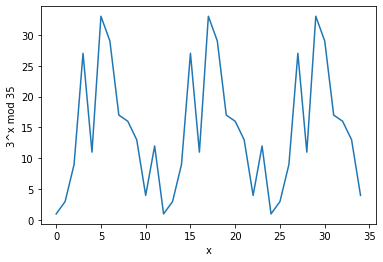

In [15]:
plot_function(3,35)

In the plot presented above we define the periodicity $r$ as the length of two consecutive points where $f(x) = 1$. This results can be used in Shor's algorithm because by performing the QFT as will be shown, we can find the period $r$ which will allow us to find the factors of $N$.

# 2. Theoretical Background: Shor's algorithm

## 2.1. The Quantum Fourier transform 

The discrete fourier transform can be written classically as
<br>
<center> $y_k = \frac{1}{\sqrt{N}}\sum^{N-1}_{j = 0} e^{2\pi ijk/N} x_j$,
<br>

which performs the DFT over a set of $N$ numbers and returns another set of the same length. It can be proved that the Quantum Fourier Transform (QFT) reads

<br>
<center> $|j\rangle \rightarrow \frac{1}{\sqrt{N}}\sum^{N-1}_{k = 0} e^{2\pi ijk/N} |k\rangle$,
<br>
    
where $j = j_1j_2...j_n$ and each $j_i$ is binary. Notice that the QFT performs a transformation of a quantum state, returing also a quantum state instead of a set of numbers. As shown in class, the previous equation can also be rewritten in a more convinient way using that the transformation of a binary number to a decimal is $j_1j_2...j_n = j_1 2^{n-1} j_2 2^{n-2} + j_n2^0 $ and then $0.j_1j_2...j_n = j_1 2^{-1} j_2 2^{-2}...j_n2^{-n} $,
    
<br>
<center> $\frac{1}{\sqrt{N}}\sum^{N-1}_{k = 0} e^{2\pi ijk/N} |k\rangle = \frac{1}{\sqrt{N}}(|0\rangle + e^{2\pi i0.j_n}|1\rangle)\cdot(|0\rangle + e^{2\pi i0.j_{n-1}j_n}|1\rangle)...(|0\rangle + e^{2\pi i0.j_1...j_n}|1\rangle)$.
<br> 

The QFT will be implemented for the phase estimation algorithm in order to undo the transformation and find the period of the function as we will see. 

## 2.2. Phase Estimation 

Shor's algorithm relies on the quantum phase estimation on a unitary operator such that 
<br>
<center> $U|y\rangle = |a y (mod N) \rangle$. 
<br>
    
For example, in the previous case where $a = 3$ and $N = 35$ we would see that starting by the state $|1\rangle$, the state will be found again after $r$ applications of $U$. Thus, a superposition of the eigenstates of these cycle would be an eigenstate of $U$ with eigenvalue 1, 

<br>
<center>
$|u_s \rangle = \frac{1}{\sqrt{r}} \sum^{r-1}_{k = 0} |a^k (mod N)\rangle$. 
<br>

We could introduce here a different phase for each $k$ which would lead to a more interesting result since we would have a unique eigenstate for every $|u_s\rangle$ as 

 <br>
<center>
$|u_s \rangle = \frac{1}{\sqrt{r}} \sum^{r-1}_{k = 0}\exp{-\frac{2\pi i s k}{r}} |a^k (mod N) \rangle$. 
<br>
    
It can be proved that the sumation of all these becomes 

<br>
<center>
$\sum_{s =0}^{s = r-1}|u_s \rangle = | 1\rangle$,
<br>
 
because all phases cancel out all the states except the state one's phases. This will be useful for the algorithm because by initializing the second register to $|1\rangle$ (which is easy to prepare), we obtain an eigenstate when implementing the unitaries. Using this result, we can develop the quantum phase estimation algorithm to measure the phase: $\phi = s/r$.  
    
Let us look at how this unitary operator acts over the register that we will call $u$. Suppose that the control qubit is in a superposition such that $H|u\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$, then the state after applying $U$ will be, 
    
<br>
<center>
$\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)\otimes U|u\rangle = \frac{1}{\sqrt{2}}(|0\rangle + e^{2\pi i \phi}|1\rangle)\otimes |u\rangle$.
<br>

Notice that this equation is the same as the one obtained for the QTF but the exponent is quite different. Let us rearrange this equation to obtain something similar to that. Taking the left hand side of the tensor 
product, the exponent is proportional to $2^{j-1}\phi$. Thus, since the exponential is periodic, we can write $\phi$ between $0$ and $1$ in the following way $\phi = \phi_1 2^{-1} +  \phi_2 2^{-2} +...+ \phi_n 2^{-n} $. 

## 2.3. Shor's algorithm 

Shor's algorithm aims to find the two prime numbers that factorize $N$. The algorithm works as follows.

1. Choose a random number $a\leq N $

2. Compute $g.c.d(a,N).$

3. If $g.c.d(a,N) = 1$, then compute $f(x) = a^x (mod N). $

4. If $g.c.d(a,N) \neq 1$, $a$ is a factor of $N$. 

5. Compute the period $r$ of the function: $f(x) = f(x + r)$

6. If $r$ is odd the factor will be a rational number and we want them to be integers. If $a^{r/2} + 1 = 0 (mod N)$, the factor will be a multiple of $N$ and therefore $g.c.d(a,N) = N$ which will not return any factor of $N$. In these cases, go to step 1. 

7. If 6 is not fulfilled then $g.c.d(a^{r/2}+1, N)$ or $g.c.d(a^{r/2}-1, N)$ are factors of $N$. 

It is important to remark two things here. The first one is that this algorithm does not work in almost every case when $N$ is even but in this situation $2$ will always be a trivial factor. Secondly, the step 7 is true because we can write $a^r = 1 (mod N) $ which implies $a^r-1 = 0 (mod N) = k\cdot N$. Since $a^r-1 = (a^{r/2}+1)(a^{r/2}-1)$ one of these two terms will be a factor of $N$. 

# 3. Circuit Implementation 

*Take into account that qubits are inversed in qiskit*

For the algorithm implementation we will need two registers: the first one with $t$ qubits will be used to represent the $j's$ and a second register that will be used to implement the unitary gates and it has to be composed with as many qubits as qubits needed to represent $N$: $\log_2{N}$. 

The full circuit of Shor's algorithm is the following. 

![shors.png](shors.png)

Where the first set of hadamards creates the superposition, the unitaries compute the operation $U|y\rangle = |ay(mod N)\rangle$ and then with the inverse QFT we can estimate the phases. 

## 3.1. QFT Implementation

For this algorithm we need to construct the inverse of the Quantum Fourier Transform as seen in the previous circuit. First, we discuss the QFT for 3 qubits which should have the expression

<br>
<center>$\frac{1}{\sqrt{2^{3/2}}}(|0\rangle + e^{2\pi i0.j_3}|1\rangle)\cdot(|0\rangle + e^{2\pi i0.j_2j_3}|1\rangle)\cdot(|0\rangle + e^{2\pi i0.j_1j_2j_3}|1\rangle)$
<br>
    
to understand then the inverse with $j_1 = q_2, j_2 = q_1$ and $j_3 = q_0$. The previous equation can be achieved by the following. 

1. Implement a Hadamard gate over the first qubit to obtain the state $(H\otimes I \otimes I)|000\rangle = \left (\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right )\otimes|00\rangle $

2. Apply the controlled phase gate which has the shape, 

<center>
$CPhase = \left ( \begin{array}\\
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
1 & 0 & 0 & e^{i\phi}
\end{array}\right )$
<center>

<br>   
    
using as target the first qubit and as control the second one and $\phi = \frac{\pi}{2}$ to obtain ${CPhase}^{\otimes(1,2)}\left (\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right )\otimes|00\rangle = \left (\frac{|0\rangle + e^{i\pi/2}|1\rangle}{\sqrt{2}}\right )\otimes|00\rangle$

    
    
3.Apply the controlled phase gate with $\phi = \frac{\pi}{4}$ using as target the first qubit and as control the second one. We have 
    
<br>
<center>${CPhase}^{\otimes(1,2)}\left(\frac{|0\rangle + e^{i\pi/2}|1\rangle}{\sqrt{2}}\right )\otimes|00\rangle = \left(\frac{|0\rangle + e^{i\pi/2}e^{i\pi/4}|1\rangle}{\sqrt{2}}\right)\otimes|00\rangle $
<br>
    
4.Implement Hadamard on the second qubit such that $\left(\frac{|0\rangle + e^{i\pi/2}e^{i\pi/4}|1\rangle}{\sqrt{2}}\right)\otimes\left ( \frac{|0\rangle + |1\rangle}{\sqrt{2}}\right )\otimes|0\rangle$
    
5.Apply a $CPhase$ with $\phi = \frac{\pi}{2}$ using as target the second qubit and as control the third one to obtain $\left(\frac{|0\rangle + e^{i\pi/2}e^{i\pi/4}|1\rangle}{\sqrt{2}}\right)\otimes\left ( \frac{|0\rangle + e^{i\pi/2}|1\rangle}{\sqrt{2}}\right )\otimes|0\rangle$.

 
6.Implement the last Hadamard on the last qubit $\left(\frac{|0\rangle + e^{i\pi/2}e^{i\pi/4}|1\rangle}{\sqrt{2}}\right)\otimes\left ( \frac{|0\rangle + e^{i\pi/2}|1\rangle}{\sqrt{2}}\right )\otimes\left (\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right)$.
 
7.Finally, the use of the $SWAP$ gate is needed since the order of the qubits is reversed in the output state.

Therefore, to construct the inverse QFT we should follow the previous steps but going from 7 to 1. 

In [4]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

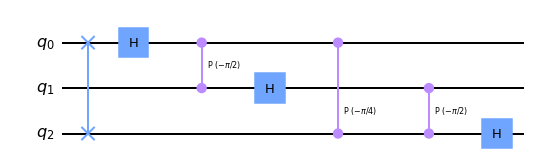

In [5]:
circuit = qft_dagger(3)
circuit.draw(output='mpl')

## 3.2. Unitaries Implementation

In this section we prepare the quantum state after the implementation of the unitary gates. These unitaries need to perform the operation $U|y\rangle = |ay(mod N)\rangle$. 

1. Creation of a vector filled with zeros of length $2^n$ with $n$ the total number of qubits. 
2. Express the different states of the first register in binary representation. 
3. Compute $|ay(mod N)\rangle$ starting with $|y\rangle = |1\rangle$ such that $U|1\rangle = |a(modN)\rangle$. 
4. Redifine the state $|y\rangle$ to $|y\rangle = |ay(mod N)\rangle $ to implement the second unitary.
5. Represent in binary the $y(modN)$ using the second set of qubits. 
6. Write a non null coefficient in front of the position of the state obtained after the first unitary. 

Repeat from step 2 to 6 for all the qubits of the first register. 

To have an idea about the performance of this function we can do an example for $a = 7$ and $N = 15$. 
We start implementing the first unitary, 

<br>
<center> $U|1\rangle = |7\cdot 1 (mod 15)\rangle = |7\rangle$
<br>
<br>    
<center> $U|7\rangle = |7\cdot 7 (mod 15)\rangle = |4\rangle$
<br>
<br>   
<center> $U|4\rangle = |7\cdot 4 (mod 15)\rangle = |13\rangle$
<br>
<br>    
<center> $U|13\rangle = |7\cdot 13 (mod 15)\rangle = |1\rangle$
<br>

For this example, a $1$ would be written in front of the states that the first register is in the state $1,7,4$ or $13$. 

In [6]:
def get_coeffs(x, N, n_q, n_count):
    vec = np.zeros(2**n_q)
    base = 1
    for i in range(2**n_count):
        s1 = np.binary_repr(i,n_count)
        mod2 = np.mod(base,N)
        base = mod2*x
        s2 = np.binary_repr(mod2,n_q-n_count)
        #print(i,'\t',mod2,'\t',s1,'\t',s2)
        vec[int(s2+s1,2)] = 1
    return vec

## 3.3. Shor's algorithm Implementation for N = 91

The implementation of Shor's algorithm for $N=91$ is presented below. The reason to choose this number is because we know that it will factorize in two prime numbers and the results will match the theoretical background of the algorithm. 

Thus, in this sections we present the functions used to compute the factors. In all functions, we have taken into account if "list_x" or "n_count" were list, because in the case they are it means that we are either doing the study of section 3.3.1 or the study for 3.3.2. (obtaining a different list for "total_counts"). 

The function "calculate_guess" has been extracted from the provided material as well as part of the function "calculate_factors".

In [7]:
def calculate_guess(N, list_x, n_count):
    
    ''' Given the number N to factorize, returns a list with the frequencies associated to 
    the different possible fractions for different values of x and qubits of the first register (t)'''
    
    total_counts = []
    # Sweeping x
    if type(list_x) == list:
        n_q = int(np.ceil(np.log2(N))) + n_count
        
        for x in list_x:
            vec = get_coeffs(x, N, n_q, n_count)
            vec = np.multiply(vec, 1/np.sqrt(2**n_count))

            Q = QuantumCircuit(n_q,n_count)
            Q.initialize(vec)
            Q.append(qft_dagger(n_count),range(n_count))
            Q.measure(range(n_count),range(n_count))
            Q.draw(fold=-1)  # -1 means 'do not fold'
            
            aer_sim = Aer.get_backend('aer_simulator')
            t_qc = transpile(Q, aer_sim)
            qobj = assemble(t_qc)
            results = aer_sim.run(qobj,shots=10000).result()
            counts = results.get_counts()
            total_counts.append(counts)
    # Sweeping t        
    elif type(n_count) == list:
        for t in n_count:
            
            n_q = int(np.ceil(np.log2(N))) + t

            vec = get_coeffs(list_x, N, n_q, t)
            vec = np.multiply(vec, 1/np.sqrt(2**t))
            
            Q = QuantumCircuit(n_q,t)
            Q.initialize(vec)
            Q.append(qft_dagger(t),range(t))
            Q.measure(range(t),range(t))
            Q.draw(fold=-1)  # -1 means 'do not fold

            aer_sim = Aer.get_backend('aer_simulator')
            t_qc = transpile(Q, aer_sim)
            qobj = assemble(t_qc)
            results = aer_sim.run(qobj,shots=10000).result()
            counts = results.get_counts()
            total_counts.append(counts)
   
    return total_counts

In [8]:
def calculate_factors(list_x, total_counts, N, n_count):
    
    ''' Given a list with the counts for each state, computes the continuous fraction
    and obtains from there the candidate factors. For every x or t, appends a dicctionary with the
    probabilities associated to each guess'''
    
    measured_phases = []
    factors_dic = []
    i = 0
    for counts in total_counts:
        freq_dic={}
        # Sweeping x
        if type(list_x) == list:
            x = list_x[i]
            t = n_count
        # Sweeping t
        elif type(list_x) != list:
            x = list_x
            t = n_count[i]
        
        for output in counts:
            decimal = int(output, 2)  # Convert (base 2) string to decimal
            phase = decimal/(2**t)  # Find corresponding eigenvalue
            measured_phases.append(phase)
          
            frac = Fraction(phase).limit_denominator(N)
            guess1 = np.gcd(x**(frac.denominator//2)-1, N)
            guess2 = np.gcd(x**(frac.denominator//2)+1, N)
             
            # Adds probability that appears a guess to the key
            if guess1 in freq_dic.keys():
                freq_dic[guess1] += 1*(counts.get(output)/20000.)
            elif guess1 is not freq_dic.keys():
                freq_dic[guess1] = 1*(counts.get(output)/20000.)
            if guess2 in freq_dic.keys():
                freq_dic[guess2] += 1*(counts.get(output)/20000.)
            elif guess2 is not freq_dic.keys():
                freq_dic[guess2] = 1*(counts.get(output)/20000.)

        factors_dic.append(dict(sorted(freq_dic.items())))
        i += 1
        
    return factors_dic

In [9]:
def plot_hist(factors_dic, list_x, n_count, N):
    
    ''' Given a list of dictionaries that contain the probabilities to obtain a factor for
     every x or register with t qubits, plots a histogram that represents the probability to 
     measure each factor vs the parameter that we are sweeping.'''
    
    fig, ax = plt.subplots()
    x = []
    # Lists the different factors in the x axis
    for i in range(len(factors_dic)):
        for j in list(factors_dic[i].keys()):
            if j in x:
                pass
            else:
                x.append(j)

    x = sorted(x)   
    
    # Plot when sweeping x
    if type(list_x) == list:   
        x_hist = np.zeros((len(list_x),len(x)))
        for i in range(len(list_x)):
            j = 0
            for guess in x:
                if guess in factors_dic[i].keys():
                    x_hist[i][j] = factors_dic[i].get(guess)
                    j += 1

        x_axis = np.arange(len(x))
        width_hist = np.linspace(-0.25,0.25,len(list_x))
        width_bar = 0.5/len(list_x)

        for i in range(len(list_x)):
            plt.bar(x_axis - width_hist[i], x_hist[i], width_bar, label = f'x = {list_x[i]}')

        plt.xticks(x_axis, x)
        plt.xlabel("Factors")
        plt.ylabel("Probability")
        plt.title(f'N = {N}, t = {n_count}')
        plt.legend()
        plt.show()
        
    # Plot when sweeping n_count
    elif type(n_count) == list:
        x_hist = np.zeros((len(n_count),len(x)))
        for i in range(len(n_count)):
            j=0
            for guess in x:
                if guess in factors_dic[i].keys():
                    x_hist[i][j] = factors_dic[i].get(guess)
                    j += 1

        x_axis = np.arange(len(x))
        width_hist = np.linspace(-0.25,0.25,len(n_count))
        width_bar = 0.5/len(n_count)

        for i in range(len(n_count)):
            plt.bar(x_axis - width_hist[i], x_hist[i], width_bar, label = f't = {n_count[i]}')

        plt.xticks(x_axis, x)
        plt.xlabel("Factors")
        plt.ylabel("Probability")
        plt.title(f'N = {N}, x = {list_x}')
        plt.legend()
        plt.show()

### 3.3.1. Comparison on the effect of different choices of x.

It has been tested the factorization of the integer $N = 91$ for different values of x. For this, we have set the parameter x to the following values: $x = 5, x = 8, x = 11, x = 15$ and $x = 27$. These values have been chosen considering that they must be coprimes with $N$ in order to obtain a good performance of the algorithm and to fulfill one of the conditions that the Euclidian algorithm imposes to calculate $g.c.d(a,b) = 1$.

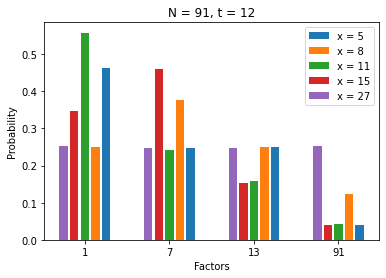

In [13]:
N = 91
list_x =[5,8,11,15,27] 
n_counts = 12       
warnings.filterwarnings('ignore', category=DeprecationWarning)
x_counts = calculate_guess(N, list_x, n_counts)
factors_dic = calculate_factors(list_x, x_counts, N, n_counts)
plot_hist(factors_dic, list_x, n_counts, N)

After this simulation we obtain the factors of $N$ which are $p = 7$ and $q = 13$ with a probability between $0.25$ and $0.45$ more or less. 

Notice how does the behaviour of the probabilities change according to the value of x. For $x = 5$, the period is $r = 24$, for $x = 8$ we have $r = 4$ and for $x = 11$ and $x = 15$ the value of the period is $r = 12$. Finally, the purple bars are for $x = 27$ and we have $r = 2$. This last value of $x$ corresponds to the worst case of the algorithm's performance since we are obtaining with the same probability all the guesses. This could be a consequence of having only two states after the inverse QFT (as the period is 2). 

### 3.3.2. Study on the effect of the size t of the working register.

Now we consider the $x$ value fixed while we do sweeps in the number of qubits of the first register. Then, the total number of qubits for each register is given by
<br>
<center> $n_q = n_{count} + \log_2{N}$, 
<br>

where $n_{count}$ stands for the number of qubits of the first register which will be the ones that we will be changing and $\log_2{N}$ corresponds to the number of qubits of the second register. Therefore, we shall compute the total number of qubits needed for this section everytime we input a different number of qubits for the first register. 

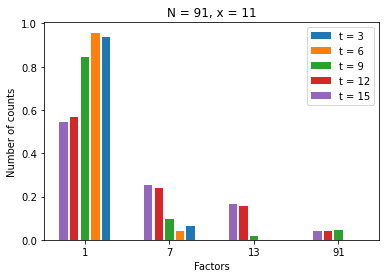

In [240]:
N = 91
list_x = 11 
n_counts = [3,6,9,12,15] 

x_counts = find_guess(N, list_x, n_counts)
list_dic = factors(list_x, x_counts, N, n_counts)
plot_hist(list_dic, list_xlista_15, n_counts, N)

The results obtained show how the factorization is accomplished more successfully when the number of qubits of the first register is increased. While for $t = 3$ and $t = 6$ the factors with the highest probability are $1$ and $7$ and $13$ has null counts, for higher number of qubits ($t = 9$, $t = 12$, $t = 15$) the probabilities of obtaining the correct factors increase.

The reason for this behaviour is because we are factoring $N = 91$ which is a large number. Therefore, we need more qubits to have enough values of f(x) to compute the periodicity of the function. As will see in the following section, the $t$ needs to fulfill $N^2 \leq 2^t \leq 2N^2$ and that is only achieved by $t= 12$ and $t= 15$ which are the ones that return greater probabilities. 

### 3.3.3. Considerations about the measurement requirements, and computational cost.

After the implementation and simulations we can conclude that the total number of qubits required for these algorithm is 

<br>
<center> $n_q = n_{count} + \log_2{N}$, 
<br>
    
as shown in section 3.3.1. However, we have not specified the number of qubits needed for the first register. Considering that $t$ represents the qubits of this first register, then this value is bounded by 
    
<br>
<center> $N^2 \leq 2^t \leq 2N^2$, 
<br>
    
because we need obtain the same value of $f(x)$ for $N$ different values of $x$. Then, knowing that the second register needs as much as qubits needed to represent the number that we want to factorize: $\log_2{N}$, the total number of qubits is of the order of $O(N^2)$. 